In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from experiments.models import model_purchase100
import experiments.data_utils

/home/enoch/g/diplomski/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tf.compat.v1.disable_eager_execution()

(x_train, y_train), (x_test, y_test), (x_shadow, y_shadow) = experiments.data_utils.load_purchase100(shadow_size=0.75)
model = model_purchase100()
model.summary()
model_weights_path="./trained_models/purchase100-weights-best.hdf5"
try:
    model.load_weights(model_weights_path)
    print("Loaded model weights successfully from file ", model_weights_path)
except:
    print("No trained model found, please check path")

./datasets/dataset_purchase
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 1024)              615424    
                                                                 
 layer2 (Dense)              (None, 512)               524800    
                                                                 
 layer3 (Dense)              (None, 256)               131328    
                                                                 
 layer4 (Dense)              (None, 128)               32896     
                                                                 
 layer5 (Dense)              (None, 100)               12900     
                                                                 
Total params: 1,317,348
Trainable params: 1,317,348
Non-trainable params: 0
_________________________________________________________________


2022-05-24 13:50:46.108566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 13:50:47.101368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 13:50:47.101778: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 13:50:47.113637: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Loaded model weights successfully from file  ./trained_models/purchase100-weights-best.hdf5


In [3]:
import cma
import optuna
import numpy as np
import pandas as pd
from cmaes import CMA

from experiments.data_utils import random_record_purchase100
from typing import Callable, Optional

def generate_zeroes(n_features):
    return np.zeros(shape=(n_features,))

def generate_class_label(n_labels, target_label):
    new_y = np.zeros(shape=(n_labels,))
    new_y[target_label] = 1
    return new_y

class CMAEvaluator():
    def __init__(self, model, y_target, target_class):
        self._model = model
        self._y_target = y_target
        self._target_class = target_class
    
    def preproc_x_float(self, x):
        np.clip(x, a_min=0, a_max=1, out=x)
        x = np.around(x)
        return x
    
    def evaluate(self, x):
        x = self.preproc_x_float(x)
        prediction = self._model.predict(x.reshape(1, -1))[0]
        class_confidence = prediction[self._target_class]
        dist = np.linalg.norm(prediction - self._y_target)
        #dist = abs(1 - class_confidence)
        return dist

def generate_class_representative_cmaes(
    target_classifier: "CLASSIFIER_TYPE",
    target_class: int,
    min_confidence: float,
    max_features_randomized: Optional[int],
    min_num_samples: Optional[int],
    max_iterations: int = 50,
    max_rejections: int = 3,
    min_features_randomized: int = 1,
    random_record_fn: Callable[[], np.ndarray] = None,
    randomize_features_fn: Callable[[np.ndarray, int], np.ndarray] = None,
) -> np.ndarray:
    import matplotlib.pyplot as plt
    
    y_target = generate_class_label(100, target_class)
    
    evaluator = CMAEvaluator(target_classifier, y_target, target_class)
    fun = evaluator.evaluate
    x_start = 600 * [0]
    cov_start = 1.3

    #x_best, es = cma.fmin2(fun, x_start, cov_start, {'seed':1337})
    
    #print("Done sampling for target class", target_class)
    #print("Best", x_best)
    #print("Deviations", es)
    
    # Predict on best solution
    #x_best = evaluator.preproc_x_float(x_best)
    #y_best = target_classifier.predict(x_best.reshape(1, -1))[0]
    #print("Prediction for x_best", y_best)
    #y_best_label = np.argmax(y_best)
    #print("Most likely class", y_best_label, " with probability ", y_best[y_best_label])
    
    # ovo se kinda vrti al nisam bas zadovoljan, ne znam uopce kakvi su rezultati
    # najbolje bi bilo da isprobam Optunu pa vidim kako ide s TPE samplerom
    
    #c = es.countiter
    #x = cfun.find_feasible(es)
    #print("find_feasible took {} iterations".format(es.countiter - c))
    #constraints(x)  # is now <= 0

    if min_num_samples is not None:
        population_size = min_num_samples
    else:
        population_size = 40
    
    optimizer = CMA(
        mean=np.zeros(600,),
        sigma=cov_start,
        population_size=population_size)
    
    for generation in range(max_iterations):
        solutions = []
        candidates = []
        if generation % 10 == 0:
            print("Running iteration", generation)
        
        for i in range(optimizer.population_size):
            x = optimizer.ask()
            value = fun(x)
            solutions.append((x, value))
            candidates.append(x)
            
        optimizer.tell(solutions)

    names = range(0, 600)
    means = optimizer._mean
    covs = optimizer._C
    print("Optimizer means", means)
    print("Optimizer covariance matrix", covs)
    plt.bar(names, means)
    plt.show()
    
    candidates = np.asarray(candidates)
    
    feature_count_and_plot_histogram(candidates, nbins=600, normalize=True)
    
    preprocessed = []
    for i in range(len(candidates)):
        preprocessed.append(evaluator.preproc_x_float(candidates[i]))
        
    preprocessed = np.asarray(preprocessed)
    
    feature_count_and_plot_histogram(preprocessed, nbins=600, normalize=True)

    # Filter multiples of same solutions
    preprocessed = np.unique(preprocessed, axis=0)
    print("Number of unique candidates after preprocessing ", preprocessed.shape)
    print("Preprocessed candidates:\n", preprocessed)
    
    predictions = target_classifier.predict(preprocessed)
    print("Prediction vectors:\n", predictions)
    
    predicted_labels = np.argmax(predictions, axis=1)
    print("Predicted labels:\n", predicted_labels)
    print(predictions[np.arange(len(predictions)), predicted_labels])
    
    
    # izgleda dobro ali mislim da bi bilo ok dodati jos nekakve perturbacije za povecanje uzorka
    # a i htio bih provjeriti jesu li svi uzorci zaista jedinstveni
    # ako zadovoljim oba uvjeta, mislim da ce algoritam biti spreman za pravu generaciju
    if len(preprocessed) != 0:
        return preprocessed, np.around(predictions)
    else:
        raise RuntimeError("Failed to synthesize data record")

def calc_2d_intersection(A, B, assume_unique=False, return_indices=False):

    nrows, ncols = A.shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)],
       'formats':ncols * [A.dtype]}

    C = np.intersect1d(A.view(dtype), B.view(dtype), assume_unique=assume_unique, return_indices=return_indices)

    # This last bit is optional if you're okay with "C" being a structured array...
    C = C.view(A.dtype).reshape(-1, ncols)
    return C

def calc_2d_intersection_sets(A, B, assume_unique=False, return_indices=False):
    aset = set([tuple(x) for x in A])
    bset = set([tuple(x) for x in B])
    return np.array([x for x in aset & bset])

def feature_count_and_plot_histogram(xs, nbins: int, normalize=True):
    xs = np.count_nonzero(xs, axis=1)
    print(xs.shape)
    s = pd.Series(xs)
    print("\nFEATURE   COUNT\n",s.value_counts(normalize))
    s.plot.hist(bins=nbins, density=normalize, range=(0, nbins))

Running iteration 0
Running iteration 10
Running iteration 20
Running iteration 30
Running iteration 40
Running iteration 50
Running iteration 60
Running iteration 70
Running iteration 80
Running iteration 90
Running iteration 100
Running iteration 110
Running iteration 120
Running iteration 130
Running iteration 140
Running iteration 150
Running iteration 160
Running iteration 170
Running iteration 180
Running iteration 190
Running iteration 200
Running iteration 210
Running iteration 220
Running iteration 230
Running iteration 240
Running iteration 250
Running iteration 260
Running iteration 270
Running iteration 280
Running iteration 290
Running iteration 300
Running iteration 310
Running iteration 320
Running iteration 330
Running iteration 340
Running iteration 350
Running iteration 360
Running iteration 370
Running iteration 380
Running iteration 390
Running iteration 400
Running iteration 410
Running iteration 420
Running iteration 430
Running iteration 440
Running iteration 450

(20,)

FEATURE   COUNT
 597    0.50
595    0.25
598    0.15
596    0.10
dtype: float64
(20,)

FEATURE   COUNT
 248    0.35
249    0.30
247    0.20
246    0.10
250    0.05
dtype: float64
Number of unique candidates after preprocessing  (19, 600)
Preprocessed candidates:
 [[1. 0. 0. ... 1. 0. 1.]
 [1. 0. 1. ... 1. 0. 1.]
 [1. 0. 1. ... 1. 0. 1.]
 ...
 [1. 0. 1. ... 1. 0. 1.]
 [1. 0. 1. ... 1. 0. 1.]
 [1. 0. 1. ... 1. 0. 1.]]
Prediction vectors:
 [[0.00088382 0.00018352 0.00518698 ... 0.00074812 0.00025775 0.0014095 ]
 [0.00104341 0.00020755 0.00523278 ... 0.00065514 0.00024659 0.00137491]
 [0.00120489 0.00017749 0.00533062 ... 0.00072143 0.00031111 0.00148816]
 ...
 [0.00181114 0.00047931 0.00657484 ... 0.00056873 0.00025173 0.00166271]
 [0.00189405 0.00027803 0.0061947  ... 0.00067629 0.00029686 0.00150896]
 [0.00209849 0.00038141 0.00704453 ... 0.00064611 0.00025492 0.00150716]]
Predicted labels:
 [75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75]
[0.67445934 0.66244954 0.66578

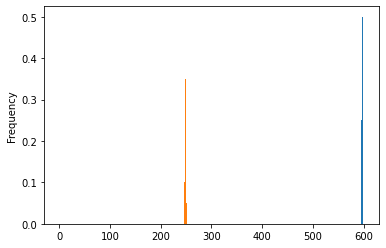

In [6]:
import time

start = time.time()

n_features = x_train[0].shape[0]
n_labels = y_train[0].shape[0]
target_class = 75
min_confidence = 0.4
max_features_randomized = n_features * 0.05
max_iterations = 1000
max_rejections = 10
min_features_randomized = 1
sample_size = 20

#print(generate_class_label(n_labels, target_class))
#print(zeros)

x_cl, y_cl = generate_class_representative_cmaes(
    model,
    target_class,
    min_confidence,
    max_features_randomized,
    min_num_samples = sample_size,
    max_iterations = max_iterations,
    max_rejections = max_rejections,
    min_features_randomized = min_features_randomized,
)

end = time.time()
print("CMA-ES duration: ", end - start)

x_cl = x_cl.astype(np.int64, casting="unsafe")
print("Generated {} vectors", x_cl.shape)

x_all = np.concatenate((x_train, x_test, x_shadow), axis=0)
y_all = np.concatenate((y_train, y_test, y_shadow), axis=0)

indices = np.where(np.argmax(y_all, axis=1) == target_class)
intersection = calc_2d_intersection_sets(x_all[indices], x_cl, assume_unique=False, return_indices=False)
print("All feature vector intersect ", intersection)

indices = np.where(np.argmax(y_train, axis=1) == target_class)
#print(x_train[indices][0])
#print(x_train.dtype)
#print(x_cl[1])
#print(x_cl.dtype)
intersection = calc_2d_intersection_sets(x_train[indices], x_cl, assume_unique=False, return_indices=False)
print("Training feature vector intersect", intersection)

#feature_count_and_plot_histogram(x_cl, nbins=600, normalize=True)

(19,)

FEATURE   COUNT
 248    0.368421
249    0.263158
247    0.210526
246    0.105263
250    0.052632
dtype: float64
(1241,)

FEATURE   COUNT
 166    0.015310
158    0.012893
136    0.012893
185    0.012893
151    0.012893
         ...   
249    0.000806
248    0.000806
247    0.000806
240    0.000806
91     0.000806
Length: 170, dtype: float64


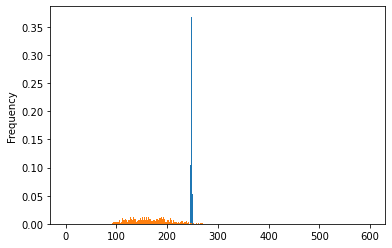

In [13]:
feature_count_and_plot_histogram(x_cl, nbins=600, normalize=True)
indices = np.where(np.argmax(y_all, axis=1) == target_class)
feature_count_and_plot_histogram(x_all[indices], nbins=600, normalize=True)

### Interpretacija rezultata
Očito, generirani vektori značajki koji maksimiziraju vjerojatnost klasifikacije za svoju klasu jako odstupaju od pravih vektora na kojima se model trenira. Mislim da se radi o sljedećem:
u originalnom radu, autori su predložili sintezu takvu da koristimo hill-climbing algoritam i perturbiramo vektor, čuvamo najbolji sample i želimo ga pomicati u smjeru u kojem maksimizira vjerojatnost klasifikacije za klasu za koju želimo generirati sample. Mislim da iz ovoga ispada da to nije dovoljno dobra heuristika, jer smo za primjere koji su klasificirani s vrlo visokom vjerojatnosti dobili značajno drugačije vektore, i čini mi se da bi trebalo u funkciju cilja dodati dodatne uvjete koji rade... što točno?

In [33]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

x_class = x_all[indices]

def plot_tsne_joint(data, labels, n_components=2, verbose=1, perplexity=40, n_iter=1000, legend="full", seed=None, use_pca=False):
    import time

    scaler = StandardScaler()
    scaler.fit(data)
    scaled = scaler.transform(data)
    
    if use_pca:
        pca = PCA(n_components, random_state=seed)
        data = pca.fit_transform(scaled)
    
    time_start = time.time()
    tsne = TSNE(n_components=n_components, verbose=verbose, perplexity=perplexity, n_iter=n_iter, random_state=seed)
    tsne_res = tsne.fit_transform(scaled)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

    #plt.figure(figsize=(16,10))
    n_colors = len(np.unique(labels, return_counts=False))
    ax = sns.scatterplot(
        x=tsne_res[:,0], y=tsne_res[:,1],
        hue=labels,
        palette=sns.color_palette("hls", n_colors),
        data=tsne_res,
        legend=legend,
        alpha=0.6
    )
    ax.set_title("t-SNE embeddings for majority (0) and minority (1) classes")
    plt.show()

def plot_pca_joint(data, labels, n_components=2, legend="full", seed=None):
    
    scaler = StandardScaler()
    scaler.fit(data)
    scaled = scaler.transform(data)
    
    pca = PCA(n_components, random_state=seed)
    pca_res = pca.fit_transform(scaled)
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))    
    print('Singular values: {}'.format(pca.singular_values_))
    
    n_colors = len(np.unique(labels, return_counts=False))
    plt.figure()
    ax = sns.scatterplot(
        x=pca_res[:,0], y=pca_res[:,1],
        hue=labels,
        palette=sns.color_palette("hls", n_colors),
        data=pca_res,
        legend="full",
        alpha=0.6
    )
    ax.set_title("PCA transform of majority (0) and minority (1) classes")
    plt.show()

1260
(1260, 600)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1260 samples in 0.000s...
[t-SNE] Computed neighbors for 1260 samples in 0.102s...


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 1260
[t-SNE] Computed conditional probabilities for sample 1260 / 1260
[t-SNE] Mean sigma: 5.258039
[t-SNE] KL divergence after 250 iterations with early exaggeration: 115.476395
[t-SNE] KL divergence after 1000 iterations: 2.426770
t-SNE done! Time elapsed: 4.476072072982788 seconds


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


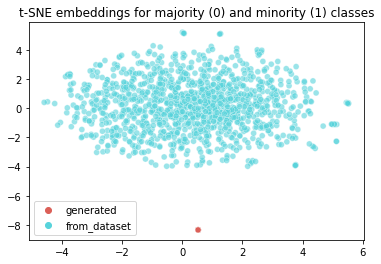

Explained variation per principal component: [0.04215513 0.02666394]


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


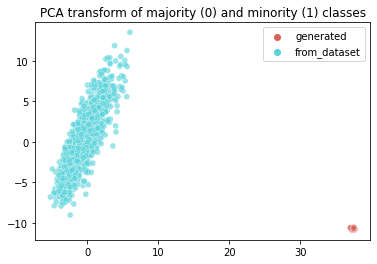

In [27]:
indices = np.where(np.argmax(y_all, axis=1) == target_class)
y_class = y_all[indices]
labels = np.concatenate((y_cl, y_class), axis=0) 
labels = len(y_cl) * ["generated"] + len(y_class) * ["from_dataset"]
data = np.concatenate((x_cl, x_class), axis=0)

print(len(labels))
print(data.shape)

plot_tsne_joint(data, labels, seed=1337, use_pca=True)
plot_pca_joint(data, labels, seed=1337)

Explained variation per principal component: [0.1684862  0.14621186]


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


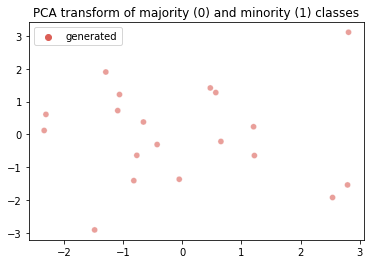

Explained variation per principal component: [0.02916344 0.01174602]


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


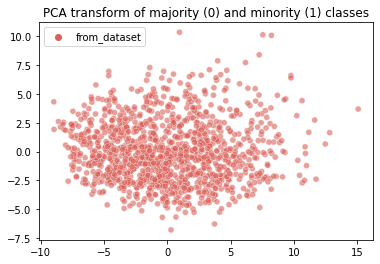

In [32]:
labels_cl = len(y_cl) * ["generated"]
plot_pca_joint(x_cl, labels, seed=1337)

labels_class = len(y_class) * ["from_dataset"]
plot_pca_joint(x_class, labels_class, seed=1337)

In [7]:
#plot_pca(x_cl)
#plot_pca(x_class)

NameError: name 'plot_pca' is not defined

In [ ]:
def plot_tsne(data, n_components=2, verbose=1, perplexity=40, n_iter=1000):
    time_start = time.time()
    tsne = TSNE(n_components=n_components, verbose=verbose, perplexity=perplexity, n_iter=n_iter)
    tsne_res = tsne.fit_transform(data)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

    #plt.figure(figsize=(16,10))
    sns.scatterplot(
        x=tsne_res[:,0], y=tsne_res[:,1],
        hue=1,
        palette=sns.color_palette("hls", 1),
        data=tsne_res,
        legend="full",
        alpha=0.6
    )
    plt.show()
    

/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 24 nearest neighbors...
[t-SNE] Indexed 25 samples in 0.001s...
[t-SNE] Computed neighbors for 25 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 25 / 25
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.882175
[t-SNE] KL divergence after 1000 iterations: 0.455106
t-SNE done! Time elapsed: 0.4306199550628662 seconds


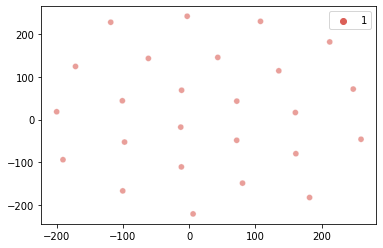

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1241 samples in 0.000s...


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 1241 samples in 0.077s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1241
[t-SNE] Computed conditional probabilities for sample 1241 / 1241
[t-SNE] Mean sigma: 2.004958
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.343315
[t-SNE] KL divergence after 1000 iterations: 2.426261
t-SNE done! Time elapsed: 4.1063666343688965 seconds


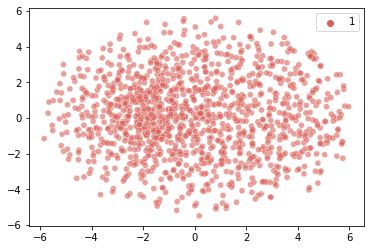

In [17]:
plot_tsne(x_cl)
plot_tsne(x_class)